# EECS 498-007/598-005 Mini-Project :- Novel View Synthesis with NeRF

In the task of novel view synthesis, training set consists of a set of images of a scene where we know the camera parameters (intrinsic and extrinsic) for each image. The goal is to create a model that can synthesize images showing the scene from new viewpoints unseen in the training set. NeRF is one such methods which tries to represent a static scene as a continuous 5D function that outputs a density and the radiance emitted in each direction (θ, φ) at each point (x, y, z) in space. The density at each point acts like a differential opacity controlling how much radiance is accumulated by passing a ray through the point (x, y, z). NeRF paper [Mildenhall et al, ECCV 2020](https://arxiv.org/abs/2003.08934) tries to predict the density and the RGB color at some input point (x, y, z) and a input viewing direction using fully-connected neural network. 

# Setup Code
This portion consists of setting up the colab environment. You'll need to rerun this setup code each time you start the notebook.

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import os
import sys
import math, imageio

GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", "data")
print(os.listdir(GOOGLE_DRIVE_PATH))

# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['drums_data_train.npz', 'drums_data_val.npz', 'drums_data_test.npz', 'lego_data_train.npz', 'lego_data_val.npz', 'lego_data_test.npz', 'lego_data.npz', 'lego_data400x400_train.npz', 'lego_data400x400_val.npz', 'lego_data400x400_test.npz', 'lego_data200x200_train.npz', 'lego_data200x200_val.npz', 'lego_data200x200_test.npz', 'drums_data100x100_train.npz', 'drums_data100x100_val.npz', 'drums_data100x100_test.npz', 'lego_data100x100_train.npz', 'lego_data100x100_val.npz', 'lego_data100x100_test.npz', 'legovideo (11).mp4', 'drumsvideo (4).mp4', '__pycache__', '.ipynb_checkpoints', 'utils.py']


Once we have successfully mounted the Google drive, we will do a sanity check to confirm the python files are loaded properly.

In [24]:
import os
from utils import hello_apna_nerf

hello_apna_nerf()

Hello Apna NeRF!


## Load Packages

Run necessary setup code and import useful packages


In [25]:
import math
import os
import time
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from utils import *

# for plotting
%matplotlib inline
plt.style.use("seaborn")  # Prettier plots
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["font.size"] = 24
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

Define GPU dependent variable

In [26]:
if torch.cuda.is_available():
    print("Good to go!")
    device = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    device = torch.device("cpu")

Good to go!


# Contents

Our project is segmented into the following parts

1. Dataset preparation and loading
2. Model initializations
3. Training Regime
4. Inference


## Dataset preparation and loading

The original NeRF implementation trains on images of resolution 800x800. Due to the restrictions on Colab we decided to try training our model on downsampled low resolution images. Even after making changes to the model architectures (which are explained in the next section), we were running out of memory for resolutions 400x400 and 200x200. Therefore we decided to use 100x100 as suggested in tiny-nerf implementation. We took the aide of `load_blender_data` function from the original NeRF implementation to load the data from their dataset and then used `transforms.resize` from `skimage` library to resize the views in the batch format ,i.e., convert `(batch_size, 800, 800, 3)` to `(batch_size, 100, 100, 3)`.

The dataset contains 100 image for training, 100 images for validation and 200 images for testing.

For this task, we will be using two synthetic rendering of objects, `drums` and `lego` mentioned in the original NeRF paper.

(100, 100, 100, 4) (100, 4, 4) 156.2500063021061


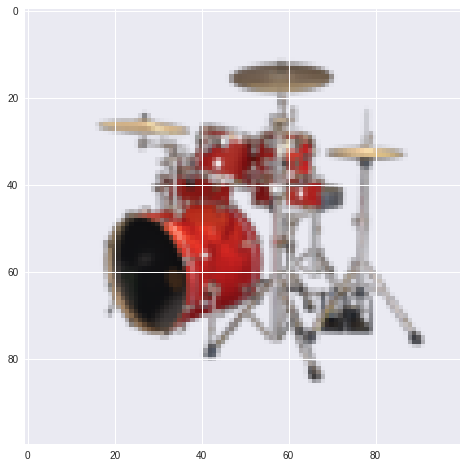

In [27]:
name = 'drums'
path = os.path.join(GOOGLE_DRIVE_PATH,name+'_data100x100_train.npz')
data = np.load(path,allow_pickle=True)
images = data['images']
poses = data['poses']
f = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, f)


# Similarly load the validation data.
path = os.path.join(GOOGLE_DRIVE_PATH,name+'_data100x100_val.npz')
data = np.load(path,allow_pickle=True)
testimg = data['images'][10]
testpose = data['poses'][10]

images = images[...,:3]
plt.imshow(testimg)
plt.show()

# Model Initializations

To implement the NeRF model and infer results as mentioned in the original paper, we had to look for other model architectures due to the GPU restrictions in Colab. The code release for NeRF included `tiny-nerf.ipynb`, that ran on low res images and modified neural architecture so that the model can be trained in Colab. Tiny-NeRF was implemented in Tensorflow so we re-implemented it in PyTorch with small changes to try and make it more understandable and improve the computation flow.

We experimented with multiple model architecture derived from Tiny-NeRF and have provided the training results for `lego` scene on 3 models, namely:

* Original Tiny-NeRF model architecture
* Tiny-NeRF architecture but reduced the number of layers
* Encoder-Decoder style architecture



## Model 1

**Original Tiny-NeRF**

The model consists of 8 fully-connected layers with width=256. The original NeRF extracts $\sigma$(the density parameter) and then applied couple layers and sigmoid activation in the end to get $rgb$ values. On the other hand Tiny-NeRF ignores the view direction and applied an linear layer to get a 4-dim vector and then applies `ReLU` on the last value to get $\sigma$ and `Sigmoid` on the first three input to get the $rgb$ value. We tweaked this a bit by concating the positional encoded view direction to the hidden layer before sending it to the last layer. The model initialization is as defined below.

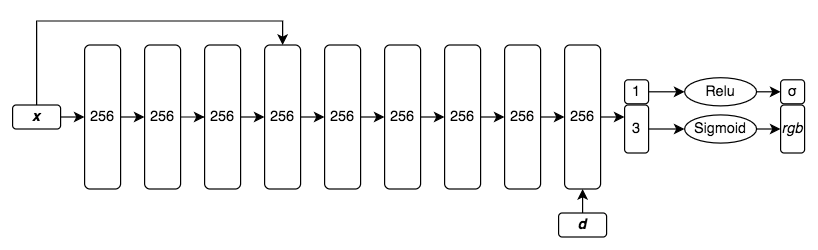

In [28]:
class NeRF_MLP_original(nn.Module):
  def __init__(self, W: int, inp_dim: int):
    super().__init__()
    self.enc = nn.Sequential(
                nn.Linear(inp_dim,W),
                nn.ReLU(),
                nn.Linear(W,W),
                nn.ReLU(),
                nn.Linear(W,W),
                nn.ReLU(),
                nn.Linear(W,W),
                nn.ReLU()
                )
    self.dec = nn.Sequential(
                nn.Linear(inp_dim+W,W),
                nn.ReLU(),
                nn.Linear(W,W),
                nn.ReLU(),
                nn.Linear(W,W),
                nn.ReLU(),
                nn.Linear(W,W),
                nn.ReLU(),
                nn.Linear(W,W),
                nn.ReLU()
                )
    self.feat_to_sigma_rgb = nn.Sequential(
                        nn.Linear(W+inp_dim,4)
                        )
    
  def forward(self, x, d):
    h = self.enc(x)
    feat = self.dec(torch.concat([x,h],dim=-1))
    obj = self.feat_to_sigma_rgb(torch.concat([feat,d], dim=-1))
    return obj

In [30]:
model_tiny_nerf_original = NeRF_MLP_original(W=256, inp_dim=39)

# Visualize model
model_tiny_nerf_original.eval()

NeRF_MLP_original(
  (enc): Sequential(
    (0): Linear(in_features=39, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
  )
  (dec): Sequential(
    (0): Linear(in_features=295, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
  )
  (feat_to_sigma_rgb): Sequential(
    (0): Linear(in_features=295, out_features=4, bias=True)
  )
)

## Model 2

**Tiny-NeRF reduced layers**

We experimented by reducing the number of layers to 6 but kept the width=256. We observed that the results this model was not that different from the original Tiny-NeRF implementation. The model initialization is as defined below.

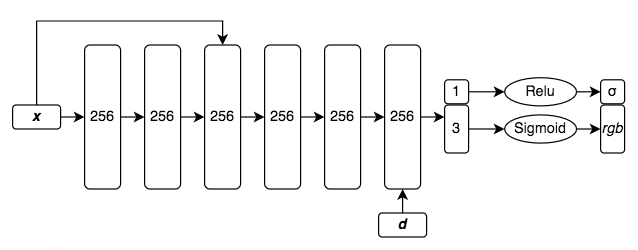

In [31]:
class NeRF_MLP_reduced(nn.Module):
  def __init__(self, W: int, inp_dim: int):
    super().__init__()
    self.enc = nn.Sequential(
                nn.Linear(inp_dim,W),
                nn.ReLU(),
                nn.Linear(W,W),
                nn.ReLU(),
                nn.Linear(W,W),
                nn.ReLU()
                )
    self.dec = nn.Sequential(
                nn.Linear(inp_dim+W,W),
                nn.ReLU(),
                nn.Linear(W,W),
                nn.ReLU(),
                nn.Linear(W,W),
                nn.ReLU()
                )
    self.feat_to_sigma_rgb = nn.Sequential(
                        nn.Linear(W+inp_dim,4)
                        )
    self.feat_to_sigma = nn.Sequential(
                        nn.Linear(W,1),
                        nn.ReLU())
    
  def forward(self, x, d):
    h = self.enc(x)
    feat = self.dec(torch.concat([x,h],dim=-1))
    obj = self.feat_to_sigma_rgb(torch.concat([feat,d], dim=-1))
    return obj

In [32]:
model_tiny_nerf_reduced = NeRF_MLP_reduced(W=256, inp_dim=39)

# Visualize model
model_tiny_nerf_reduced.eval

<bound method Module.eval of NeRF_MLP_reduced(
  (enc): Sequential(
    (0): Linear(in_features=39, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
  )
  (dec): Sequential(
    (0): Linear(in_features=295, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
  )
  (feat_to_sigma_rgb): Sequential(
    (0): Linear(in_features=295, out_features=4, bias=True)
  )
  (feat_to_sigma): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): ReLU()
  )
)>

## Model 3

**Encoder-Decoder Architecture**

Next implemented a encoder-decoder type architecture to see if how it affects our results. The encoder model reduces the width from 512 to 100 and decoder width goes from 100 to 512. Again we haven't seen much difference in the results. The model initialization is as defined below.

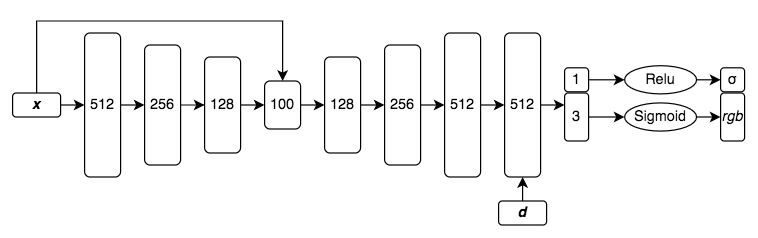

In [33]:
class NeRF_MLP_autoencoder(nn.Module):
  def __init__(self, W: int, inp_dim: int):
    super().__init__()
    self.enc = nn.Sequential(
                nn.Linear(inp_dim,512),
                nn.ReLU(),
                nn.Linear(512,256),
                nn.ReLU(),
                nn.Linear(256,128),
                nn.ReLU(),
                nn.Linear(128,100),
                nn.ReLU()
                )
    self.dec = nn.Sequential(
                nn.Linear(inp_dim+100,128),
                nn.ReLU(),
                nn.Linear(128,256),
                nn.ReLU(),
                nn.Linear(256,512),
                nn.ReLU(),
                nn.Linear(512,512),
                nn.ReLU()
                )
    self.feat_to_sigma_rgb = nn.Sequential(
                        nn.Linear(W+inp_dim,4)
                        )
    self.feat_to_sigma = nn.Sequential(
                        nn.Linear(W,1),
                        nn.ReLU())
    
  def forward(self, x, d):
    h = self.enc(x)
    feat = self.dec(torch.concat([x,h],dim=-1))
    obj = self.feat_to_sigma_rgb(torch.concat([feat,d], dim=-1))
    return obj

In [34]:
model_tiny_nerf_autoencoder = NeRF_MLP_autoencoder(W=256, inp_dim=39)

# Visualize model
model_tiny_nerf_original.eval

<bound method Module.eval of NeRF_MLP_original(
  (enc): Sequential(
    (0): Linear(in_features=39, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
  )
  (dec): Sequential(
    (0): Linear(in_features=295, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
  )
  (feat_to_sigma_rgb): Sequential(
    (0): Linear(in_features=295, out_features=4, bias=True)
  )
)>

# Training Regime

We have followed the implementation of Tiny-NeRF and coded the training regime in PyTorch. We have chosen `N_sample=64` and `N_iter=2000`. In each iteration we randomly select an image, generate a direction rays, `dir_rays` and sample `N_samples` points along the rays to create `origin_rays` using `project_rays` function. Positional encoding is then applied on `origin_rays` and `dir_rays` with 6 embedded dimension. We pass the encoded points and rays to our model and predict the RGB color and corresponding opacity for each of the 3D points. We then use this information to render color for each pixel. We then take an mean squared loss between the predicted colors(`pred_rgb`) and target color of each pixels. The gradient are calculated and backprogated w.r.t the MSE loss.



The implementation for sampling points along rays, runnnig the model on batches of 3D points and rendering an image based on the predicted $rgb$ and $\sigma$ values has been done in `render_rays()`. We have followed the mathematical formulation of differentiable volumen rendering and implemented the function in PyTorch.

Sampling from the rays follows the stratified sampling process as defined in Equation 2 in the paper(which has been mentioned below). We evenly segment `N = N_samples` samples between $[t_n,t_f]$(where $t_n$ and $t_f$ are near and far planes respectively). For each each interval $[t_i,t_{i+1}]$ we uniformly sample a point in the interval. 
$$t_i \sim \mathcal{U}\big[ t_n+\frac{i-1}{N}(t_f - t_n), t_n+\frac{i}{N}(t_f - t_n) \big]$$


Once we have the predicted $rgb$ and $\sigma$ values for each point in a ray we use the following rendering function, as mentioned in the paper, to get the color at the pixel through which the ray was projected.
$$\hat{C}(\textbf{r}) = \sum_{i=1}^N exp\left(-\sum_{j=1}^{i-1}\sigma_j\delta_j\right) \Bigg(1-exp(-\sigma_i\delta_i) \Bigg)\textbf{c}_i$$
where $\delta_i = t_{i+1} - t_i$ and $c_i$ is color value. 



In [ ]:
def convert_to_batch(model,pts, rays_d, batch_size):
  '''
  Call model in smaller batches
  Input:-
    model : pytorch model instance describing MLP model.
    pts : `N_sample` samples between [tn,tf] along the rays `rays_d`for each pixels in the image
    rays_d : direction rays for each pixel in the image.
    batch_size : Maximum number of rays to process simultaneously. Use it to control memory usage
  
  Output:-
    model output predicting `rgb` and `sigma` value for each pixels in the image.
  '''
  return torch.cat([model.forward(pts[i:i+batch_size],rays_d[i:i+batch_size]) for i in range(0,pts.shape[0],batch_size)],0)



def render_rays(model,rays_o, rays_d, near, far, N_samples, rand=False, batch_size=1024,L=6):
  '''
  Rendering function

  Input:-
    model : Pytorch model instance describing MLP model.
    rays_o : origin ray for each pixels in the image.
    rays_d : direction ray for each pixel in the image.
    near : Near plane.
    far : Far plane.
    N_samples : Number of sample to take along each ray.
    batch_size : Maximum number of rays to process simultaneously. Use it to control memory usage
  
  Output:-
    rgb : Estimated RGB color of a ray.
    depth : Depth map.
    acc : accumulated opacity along each ray. 
  '''
  z_vals = torch.linspace(near,far,N_samples,dtype=rays_o.dtype,device=rays_o.device)
  if(rand):
    sz = list(rays_o.shape[:-1]) + [N_samples]
    temp = torch.rand(sz)*(far-near)/N_samples
    z_vals = z_vals.unsqueeze(0).unsqueeze(0) + temp.to(rays_o)
  pts = rays_o.unsqueeze(-2) + rays_d.unsqueeze(-2)*z_vals.unsqueeze(-1)

  # Run model
  H, W, P, PP = pts.shape
  pts = pts.reshape(-1,3)
  pts = positional_encoding(pts,L)
  
  rays_d = rays_d.unsqueeze(-2)
  rays_d = rays_d.repeat(1, 1, P, 1).reshape(-1,3)
  rays_d = positional_encoding(rays_d, L)
  
  obj = convert_to_batch(model,pts,rays_d,batch_size)
  out_rgb = torch.sigmoid(obj[...,:3])
  out_sigma = torch.relu(obj[...,-1])
  out_rgb = out_rgb.reshape(H, W, P, 3)
  out_sigma = out_sigma.reshape(H, W, P)

  # Do Volume rendering
  diff = z_vals[...,1:]-z_vals[...,:-1]

  sz = list(diff.shape[:-1])+[1]
  distance = torch.concat((diff,torch.ones(sz,dtype=diff.dtype,device=diff.device)*1e10),axis=-1)
  alpha = 1 - torch.exp(-out_sigma*distance)
  
  sz = list(alpha.shape[:-1]) + [1]
  apx = torch.cat([torch.ones(sz,dtype=z_vals.dtype,device=z_vals.device),1.0 -alpha + 1e-10],-1)
  weights = alpha * torch.cumprod(apx,-1)[...,:-1]

  rgb = torch.sum(weights.unsqueeze(-1)*out_rgb,-2)
  depth = torch.sum(weights*z_vals,-1)
  acc = torch.sum(weights,-1)
  
  return rgb,depth,acc


Before training, we need to define the hyper-parameters as a Python dictionary. In order to keep the memory-footprint somewhat reasonable, we keep the number of samples (```num_samples```) as 64, you can always increase this for slightly better results.

In [ ]:
hparams = {
    'network_width': 256,
    'lr': 5e-3,
    'iterations': 2000,
    'num_samples': 64,
    'L': 6,
    'batch_size': 1024*64,
    'near': 2.0,
    'far': 6.0
}

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loss at iteration 0 is 0.10267665982246399
PSNR at iteration 0 is 7.793004415023352
SSIM at iteration 0 is 0.00757611241715231


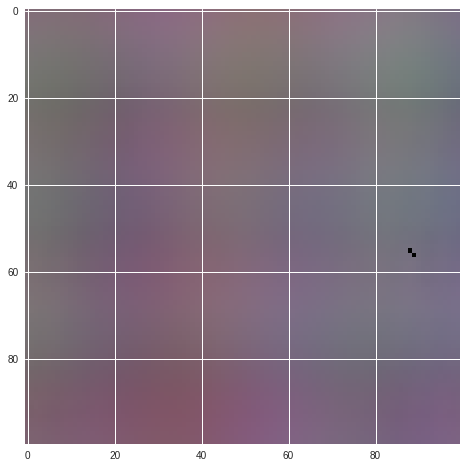

Loss at iteration 25 is 0.050765544176101685
PSNR at iteration 25 is 14.169114467987088
SSIM at iteration 25 is 0.014400632260346049


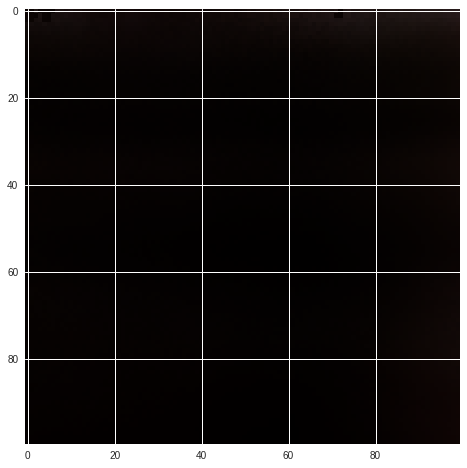

Loss at iteration 50 is 0.032365959137678146
PSNR at iteration 50 is 15.052068280422446
SSIM at iteration 50 is 0.10595977810817975


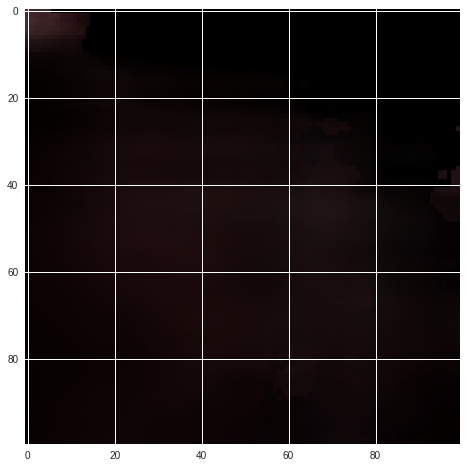

Loss at iteration 75 is 0.047463513910770416
PSNR at iteration 75 is 16.558678231491605
SSIM at iteration 75 is 0.22926196643598531


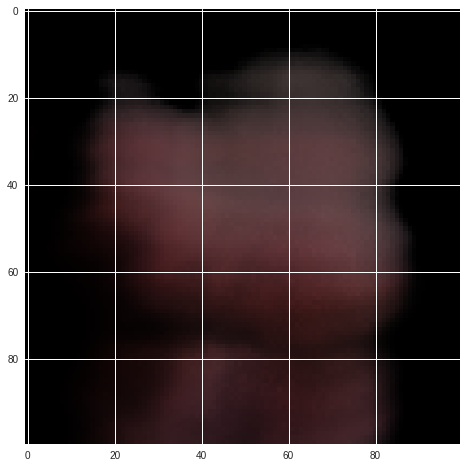

Loss at iteration 100 is 0.03343982994556427
PSNR at iteration 100 is 16.323894569690747
SSIM at iteration 100 is 0.43999393365683664


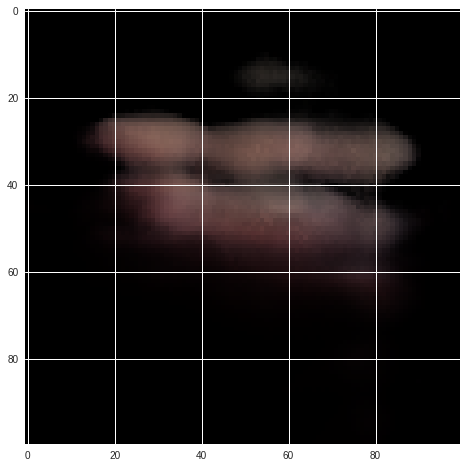

Loss at iteration 125 is 0.017196644097566605
PSNR at iteration 125 is 17.76331386594522
SSIM at iteration 125 is 0.4840098310935223


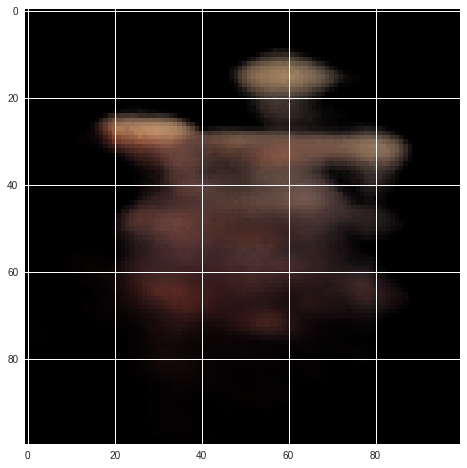

Loss at iteration 150 is 0.013247965835034847
PSNR at iteration 150 is 16.502752114651816
SSIM at iteration 150 is 0.5124172975446764


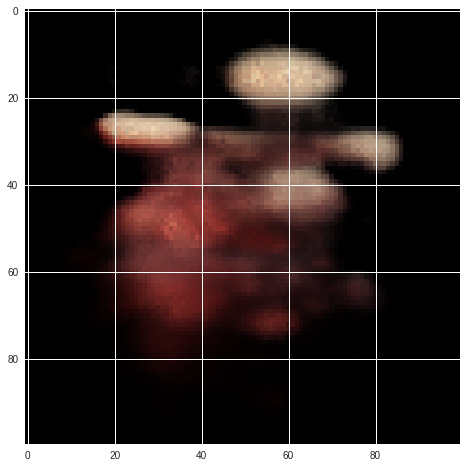

Loss at iteration 175 is 0.01639110967516899
PSNR at iteration 175 is 18.555588095910736
SSIM at iteration 175 is 0.4856045040831121


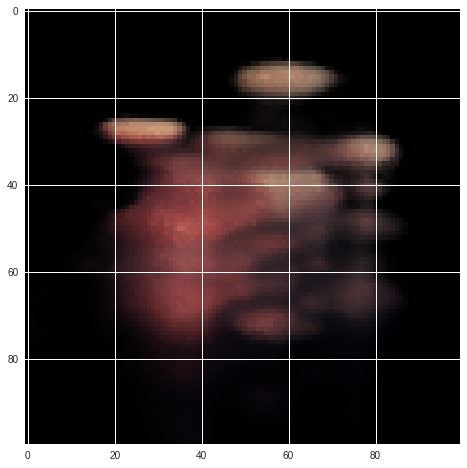

Loss at iteration 200 is 0.012326976284384727
PSNR at iteration 200 is 18.484327131437144
SSIM at iteration 200 is 0.4863858835784406


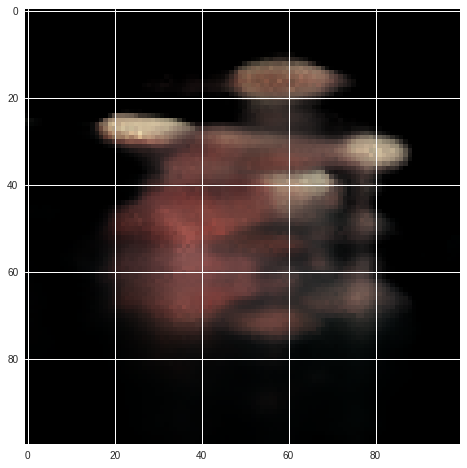

Loss at iteration 225 is 0.01154573354870081
PSNR at iteration 225 is 17.574422919662638
SSIM at iteration 225 is 0.5609655648214755


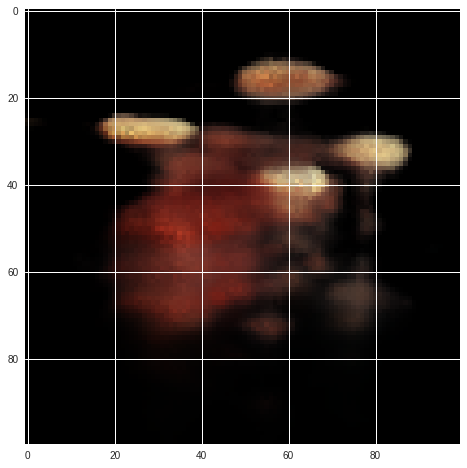

Loss at iteration 250 is 0.012357328087091446
PSNR at iteration 250 is 17.73522241312245
SSIM at iteration 250 is 0.5366634534133466


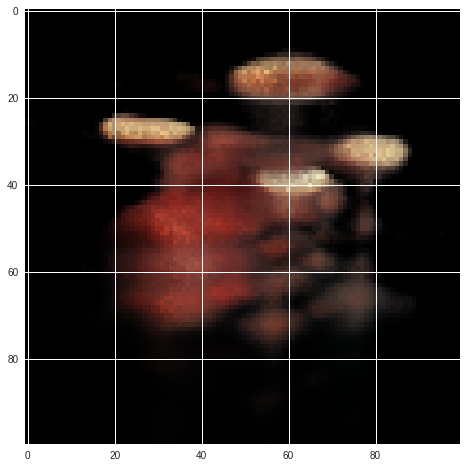

Loss at iteration 275 is 0.00991521030664444
PSNR at iteration 275 is 17.581283736706634
SSIM at iteration 275 is 0.5828191896547195


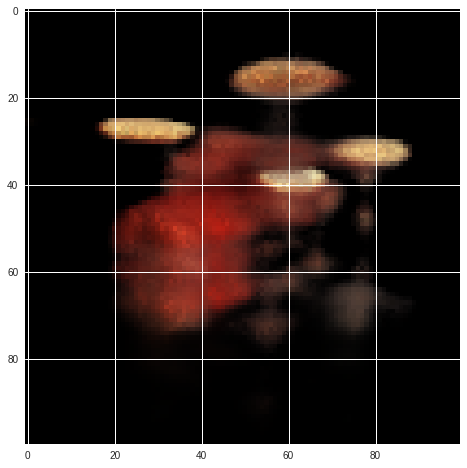

Loss at iteration 300 is 0.01485415082424879
PSNR at iteration 300 is 18.569725976369348
SSIM at iteration 300 is 0.5928953438138946


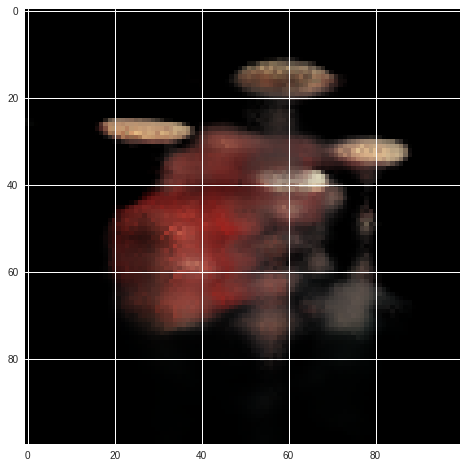

Loss at iteration 325 is 0.0070344554260373116
PSNR at iteration 325 is 19.622131408316385
SSIM at iteration 325 is 0.6163063404087987


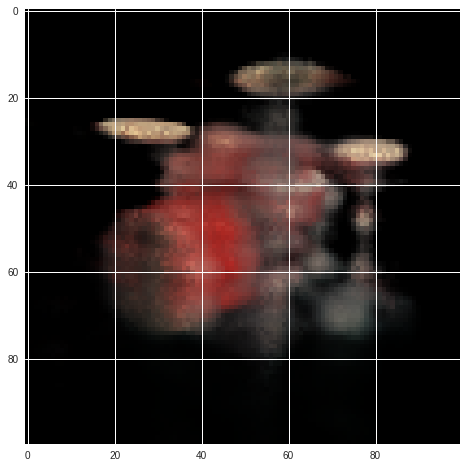

Loss at iteration 350 is 0.008281330578029156
PSNR at iteration 350 is 18.89549363962751
SSIM at iteration 350 is 0.5786310627034812


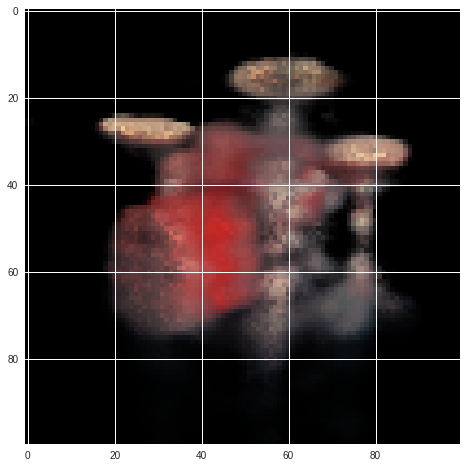

Loss at iteration 375 is 0.006287956610321999
PSNR at iteration 375 is 18.78229947735014
SSIM at iteration 375 is 0.6218689961104285


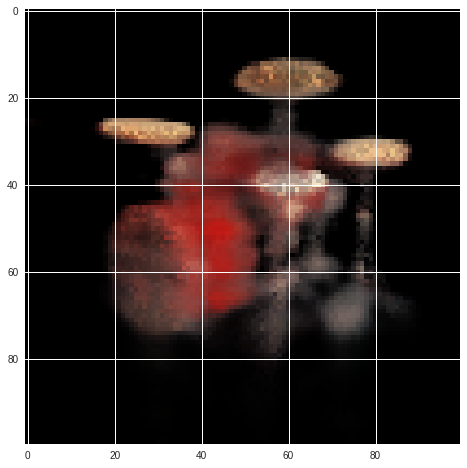

Loss at iteration 400 is 0.006558567751199007
PSNR at iteration 400 is 18.353458029989675
SSIM at iteration 400 is 0.5995124133009366


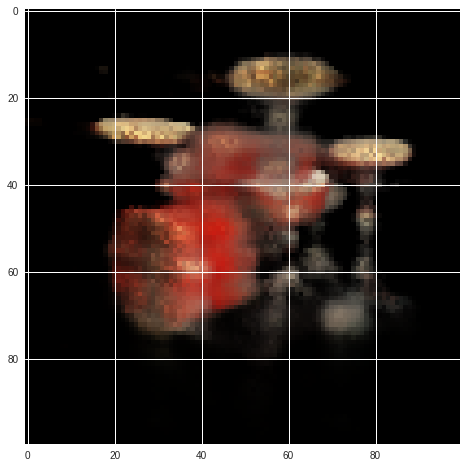

Loss at iteration 425 is 0.008498099632561207
PSNR at iteration 425 is 19.17568957337459
SSIM at iteration 425 is 0.6208693617792985


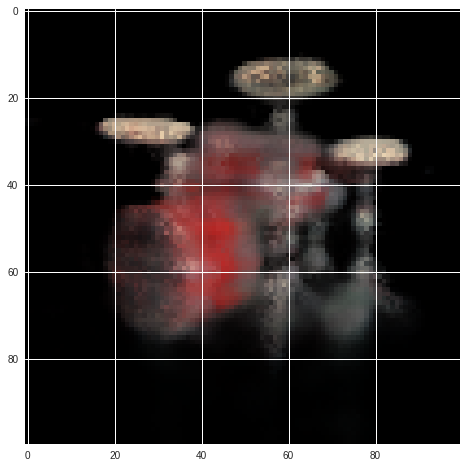

Loss at iteration 450 is 0.005264454986900091
PSNR at iteration 450 is 19.199125693654377
SSIM at iteration 450 is 0.6171634492028237


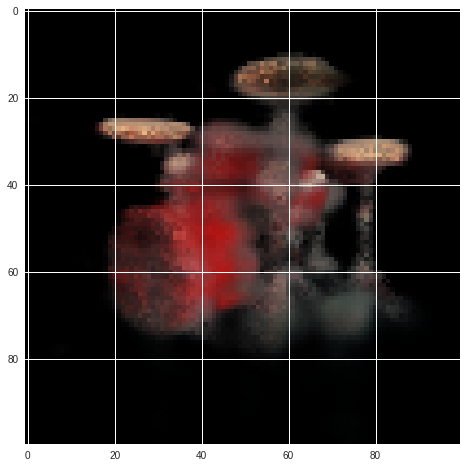

Loss at iteration 475 is 0.006647394970059395
PSNR at iteration 475 is 19.141971546477407
SSIM at iteration 475 is 0.6576879328471437


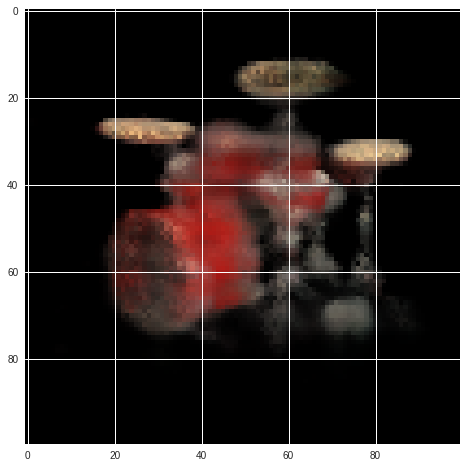

Loss at iteration 500 is 0.006569636054337025
PSNR at iteration 500 is 19.49199953924672
SSIM at iteration 500 is 0.6843154412370434


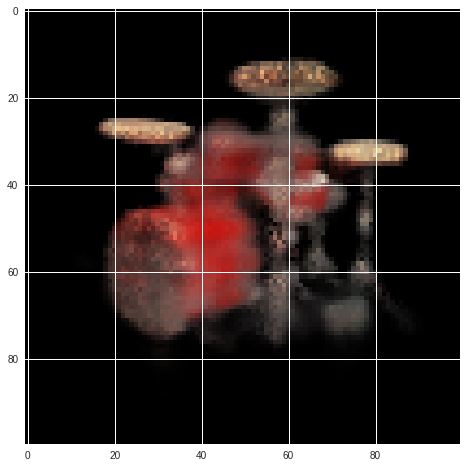

Loss at iteration 525 is 0.007167341187596321
PSNR at iteration 525 is 19.590542243453978
SSIM at iteration 525 is 0.6589568121858438


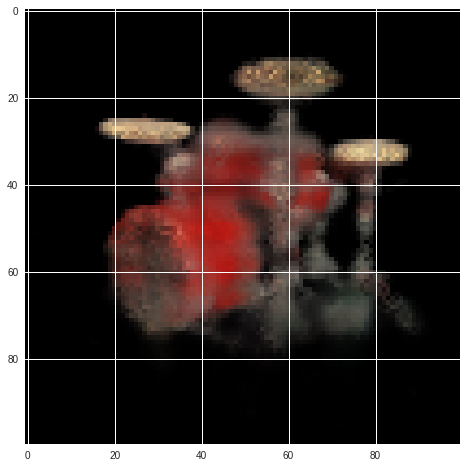

Loss at iteration 550 is 0.006492519285529852
PSNR at iteration 550 is 19.408984274277582
SSIM at iteration 550 is 0.6701264234873412


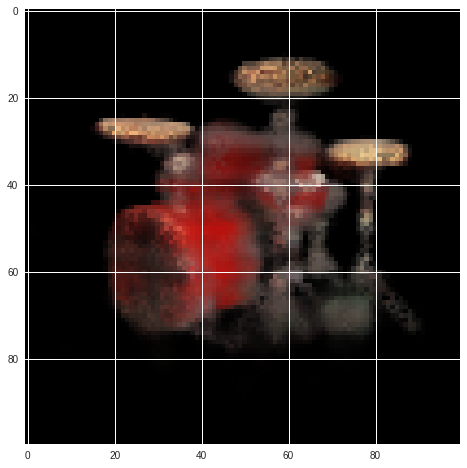

Loss at iteration 575 is 0.008124091662466526
PSNR at iteration 575 is 19.800547856377253
SSIM at iteration 575 is 0.686668694297921


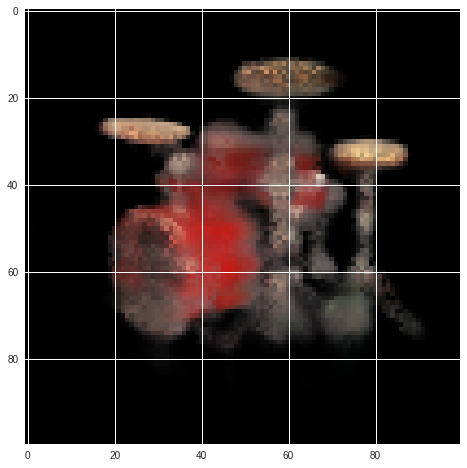

Loss at iteration 600 is 0.007981428876519203
PSNR at iteration 600 is 19.92417924108196
SSIM at iteration 600 is 0.6865907222047762


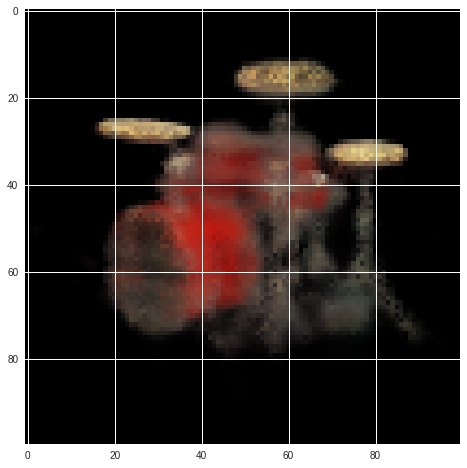

Loss at iteration 625 is 0.007693780120462179
PSNR at iteration 625 is 19.439233581419654
SSIM at iteration 625 is 0.692221381475577


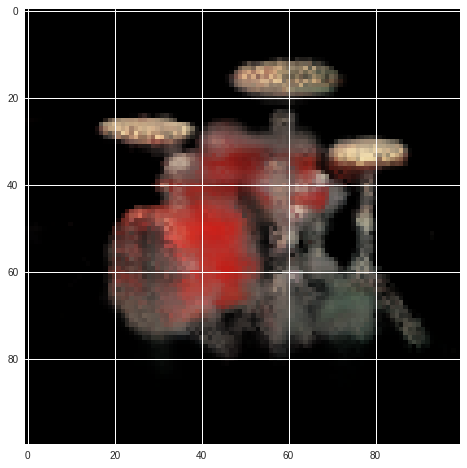

Loss at iteration 650 is 0.006864334922283888
PSNR at iteration 650 is 20.013887582020367
SSIM at iteration 650 is 0.7066150351338808


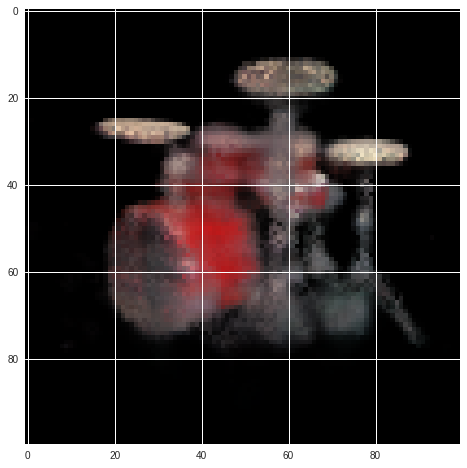

Loss at iteration 675 is 0.006219853647053242
PSNR at iteration 675 is 20.12190455063339
SSIM at iteration 675 is 0.7096282400120775


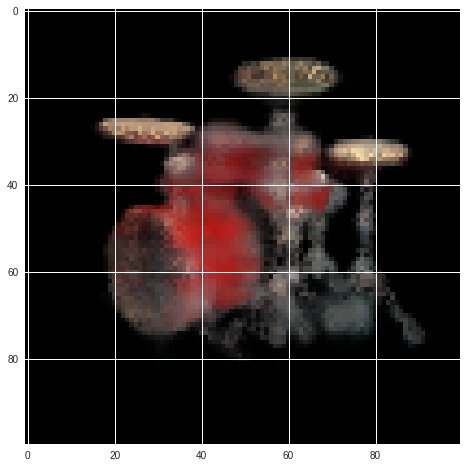

Loss at iteration 700 is 0.006347722373902798
PSNR at iteration 700 is 20.25225386183696
SSIM at iteration 700 is 0.7191863565906896


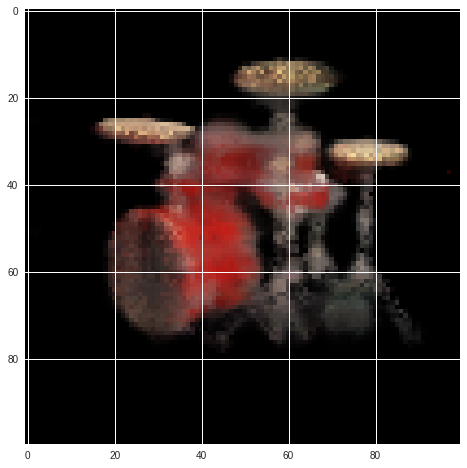

Loss at iteration 725 is 0.00748114800080657
PSNR at iteration 725 is 19.91420796608442
SSIM at iteration 725 is 0.6928538979990362


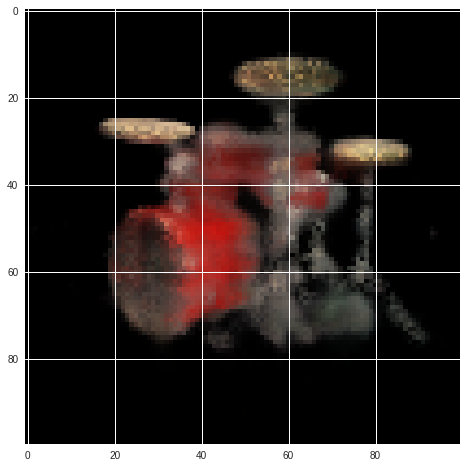

Loss at iteration 750 is 0.006315121427178383
PSNR at iteration 750 is 19.752132812105707
SSIM at iteration 750 is 0.6975730246682892


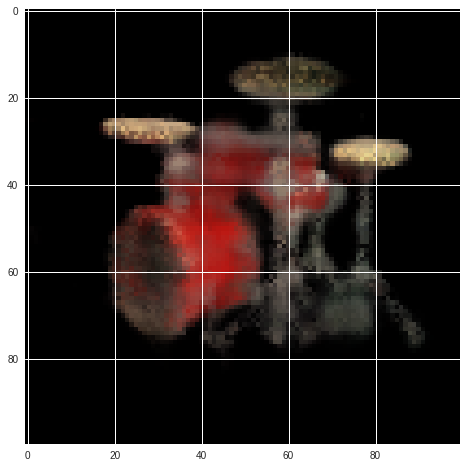

Loss at iteration 775 is 0.005403899122029543
PSNR at iteration 775 is 19.848180108966748
SSIM at iteration 775 is 0.7106242744598682


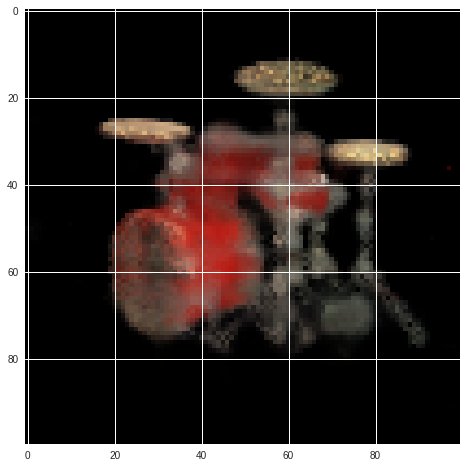

Loss at iteration 800 is 0.0058512939140200615
PSNR at iteration 800 is 20.263007928516547
SSIM at iteration 800 is 0.7260783879854298


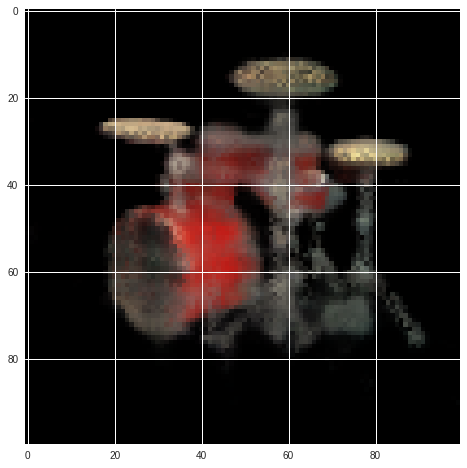

Loss at iteration 825 is 0.007063200231641531
PSNR at iteration 825 is 19.798232615370555
SSIM at iteration 825 is 0.7036950581270925


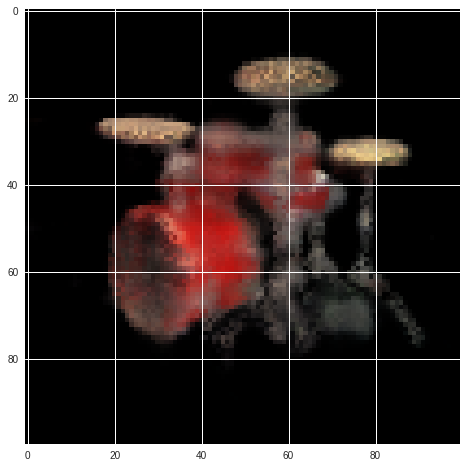

Loss at iteration 850 is 0.0047085704281926155
PSNR at iteration 850 is 20.66142404415035
SSIM at iteration 850 is 0.7407615067185227


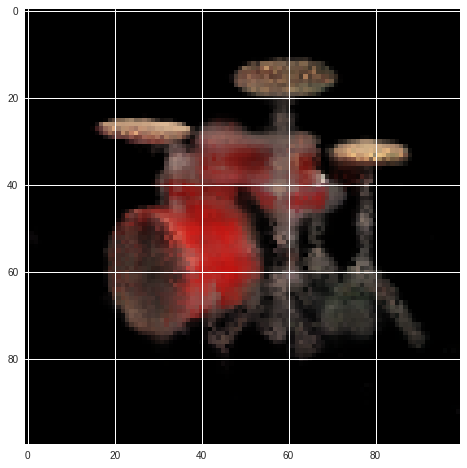

Loss at iteration 875 is 0.006833664141595364
PSNR at iteration 875 is 20.65522176614046
SSIM at iteration 875 is 0.7284752000717764


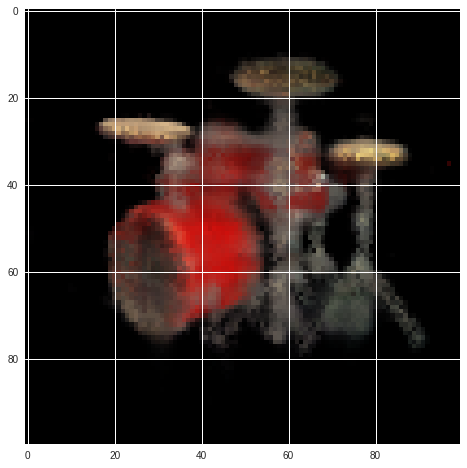

Loss at iteration 900 is 0.005884177517145872
PSNR at iteration 900 is 20.193490642869104
SSIM at iteration 900 is 0.6996444292225692


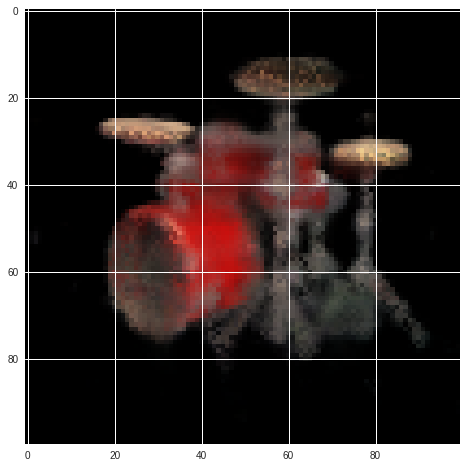

Loss at iteration 925 is 0.005236471071839333
PSNR at iteration 925 is 19.860541176559753
SSIM at iteration 925 is 0.7221765852057939


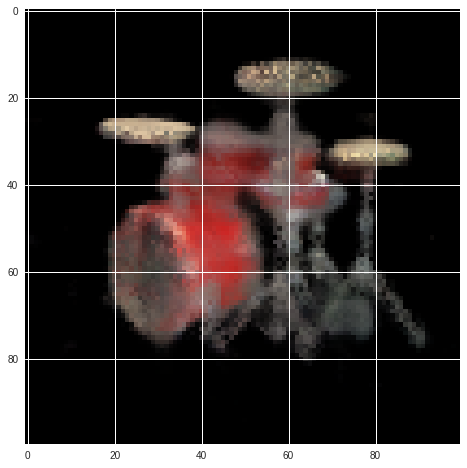

Loss at iteration 950 is 0.006307526491582394
PSNR at iteration 950 is 19.612907720083975
SSIM at iteration 950 is 0.7160184836530956


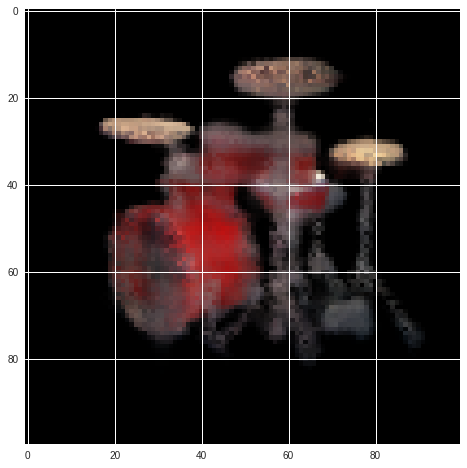

Loss at iteration 975 is 0.005285151768475771
PSNR at iteration 975 is 19.972095203884262
SSIM at iteration 975 is 0.7213221815891723


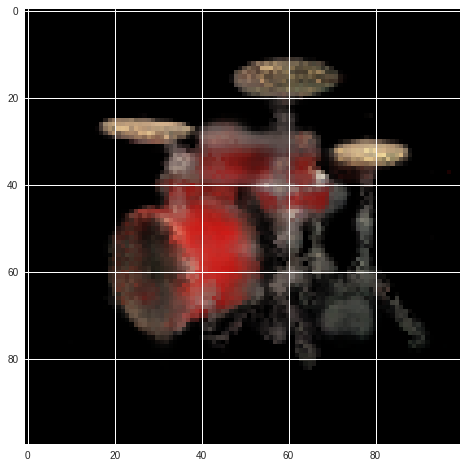

Loss at iteration 1000 is 0.003539342200383544
PSNR at iteration 1000 is 20.008513654996772
SSIM at iteration 1000 is 0.7224924109509713


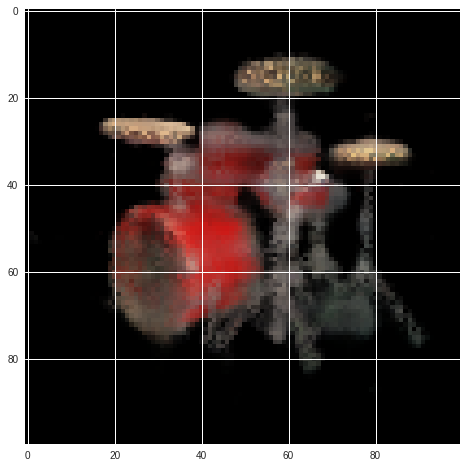

Loss at iteration 1025 is 0.005195695906877518
PSNR at iteration 1025 is 20.891560656918088
SSIM at iteration 1025 is 0.7468427715294309


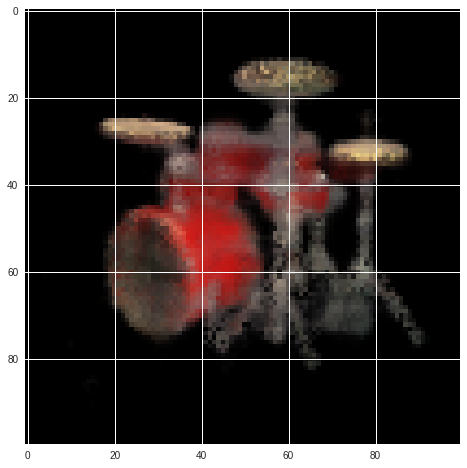

Loss at iteration 1050 is 0.005905312951654196
PSNR at iteration 1050 is 20.45064599393236
SSIM at iteration 1050 is 0.7106640910213438


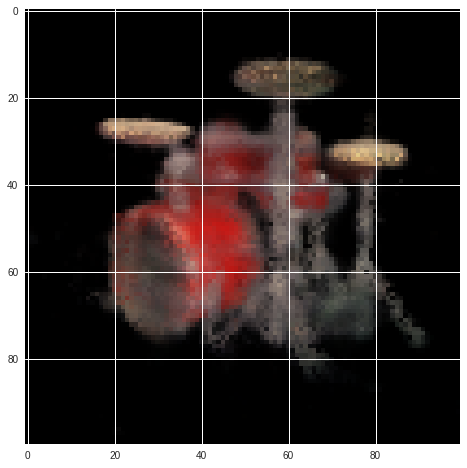

Loss at iteration 1075 is 0.005828160792589188
PSNR at iteration 1075 is 19.800477446543418
SSIM at iteration 1075 is 0.7138998980983793


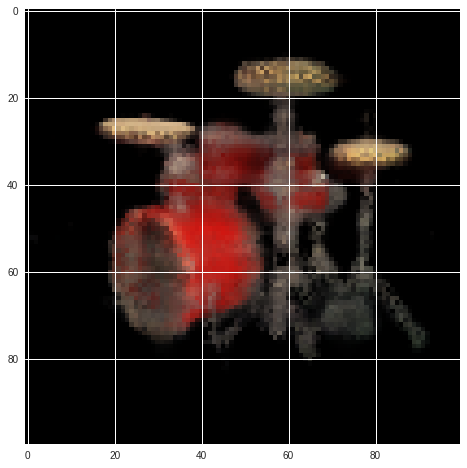

Loss at iteration 1100 is 0.007090304978191853
PSNR at iteration 1100 is 20.134271830858793
SSIM at iteration 1100 is 0.7248746942128933


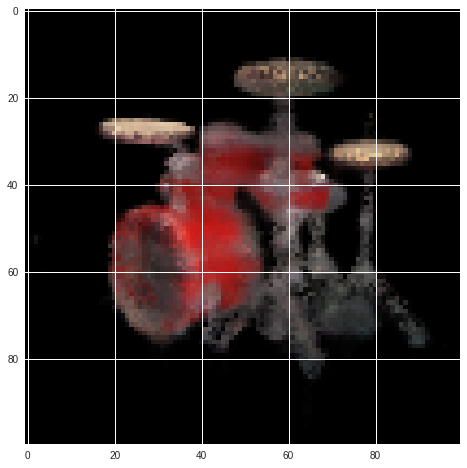

Loss at iteration 1125 is 0.004544246941804886
PSNR at iteration 1125 is 20.476343512404732
SSIM at iteration 1125 is 0.7412606767855516


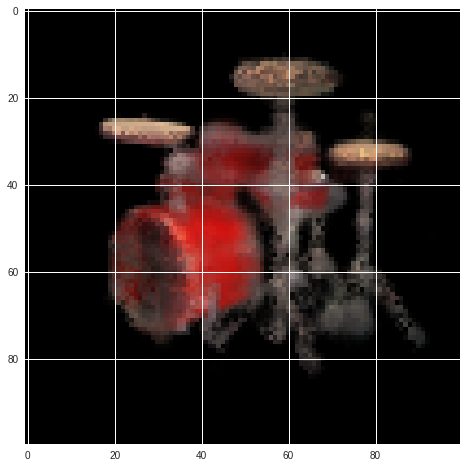

Loss at iteration 1150 is 0.005239216145128012
PSNR at iteration 1150 is 20.43707139214443
SSIM at iteration 1150 is 0.7496457574773481


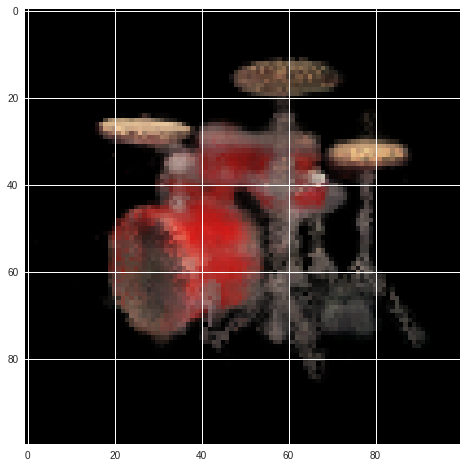

Loss at iteration 1175 is 0.004553093574941158
PSNR at iteration 1175 is 20.49435186284681
SSIM at iteration 1175 is 0.7558725545696281


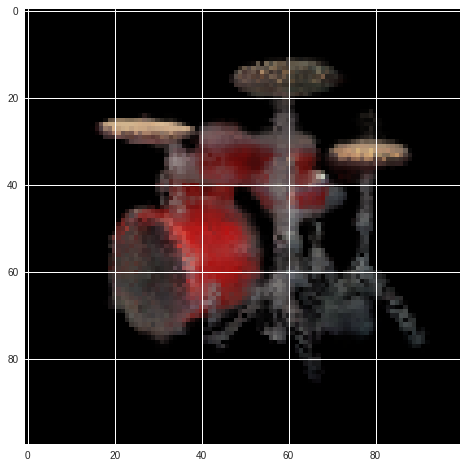

Loss at iteration 1200 is 0.004846229217946529
PSNR at iteration 1200 is 20.405049413891685
SSIM at iteration 1200 is 0.7409921179473264


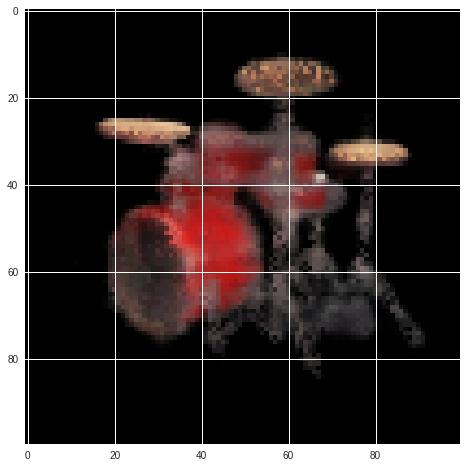

Loss at iteration 1225 is 0.0036920125130563974
PSNR at iteration 1225 is 20.6121268060784
SSIM at iteration 1225 is 0.7619916913974798


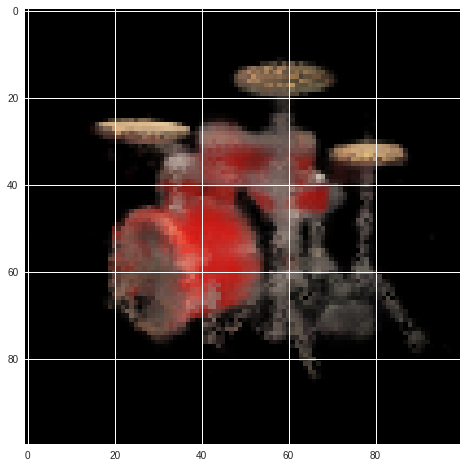

Loss at iteration 1250 is 0.008366691879928112
PSNR at iteration 1250 is 20.445191302687597
SSIM at iteration 1250 is 0.7563790225446039


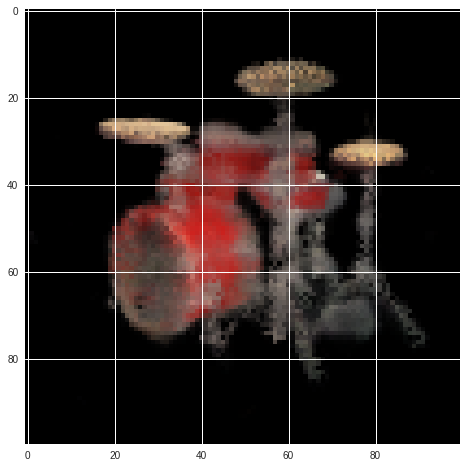

Loss at iteration 1275 is 0.004531635902822018
PSNR at iteration 1275 is 20.404088526747582
SSIM at iteration 1275 is 0.7325048065914604


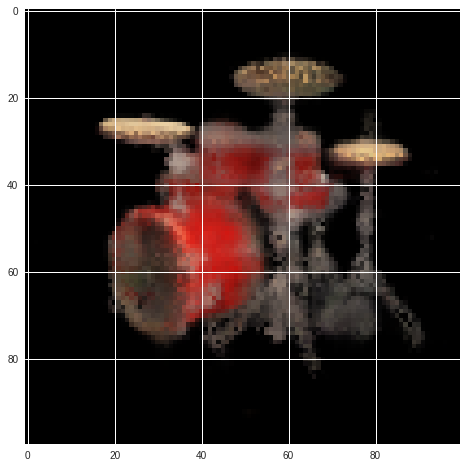

Loss at iteration 1300 is 0.003826656611636281
PSNR at iteration 1300 is 20.743093238766757
SSIM at iteration 1300 is 0.7538387937484584


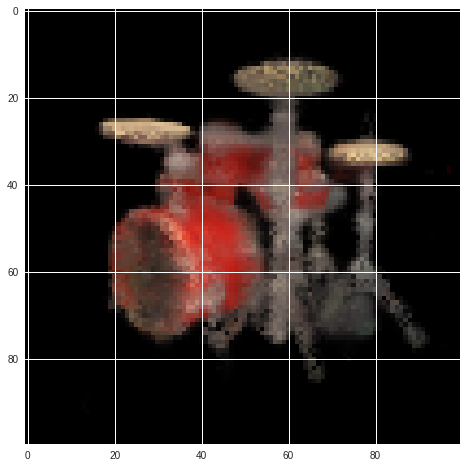

Loss at iteration 1325 is 0.005731332581490278
PSNR at iteration 1325 is 20.970837988061565
SSIM at iteration 1325 is 0.7725508935991383


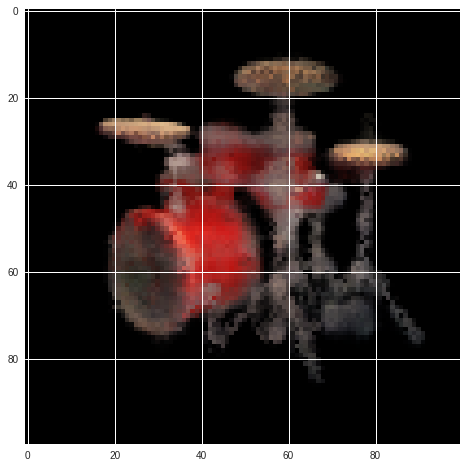

Loss at iteration 1350 is 0.005465299356728792
PSNR at iteration 1350 is 20.968479258628086
SSIM at iteration 1350 is 0.7691442641112102


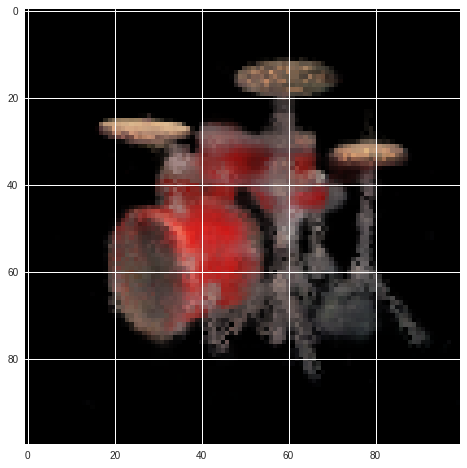

Loss at iteration 1375 is 0.004376750905066729
PSNR at iteration 1375 is 21.22574022444209
SSIM at iteration 1375 is 0.7865739390023262


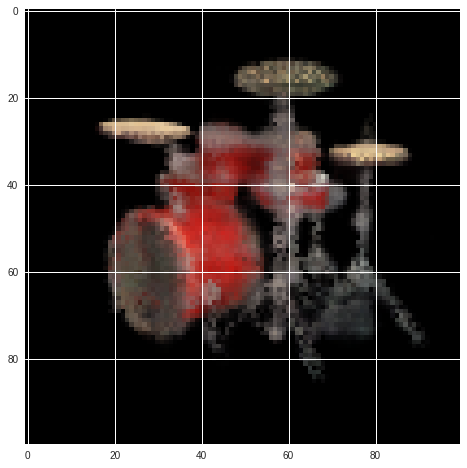

Loss at iteration 1400 is 0.005985862575471401
PSNR at iteration 1400 is 21.003897475924646
SSIM at iteration 1400 is 0.7825682341051421


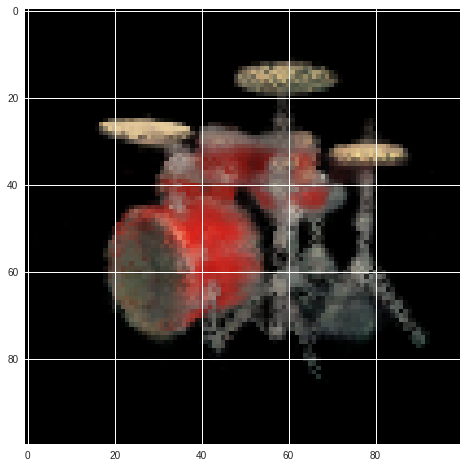

Loss at iteration 1425 is 0.005535750184208155
PSNR at iteration 1425 is 20.789062576751267
SSIM at iteration 1425 is 0.7555282671263628


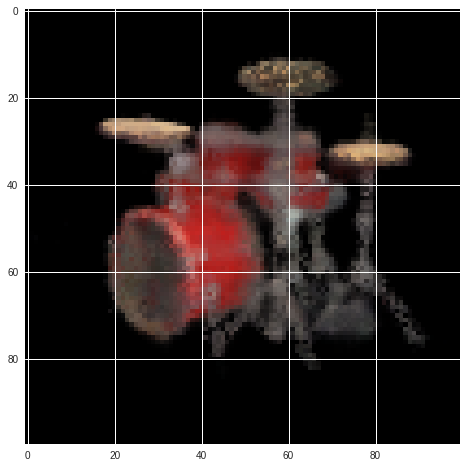

Loss at iteration 1450 is 0.0070939636789262295
PSNR at iteration 1450 is 20.584122330109192
SSIM at iteration 1450 is 0.7843941905895693


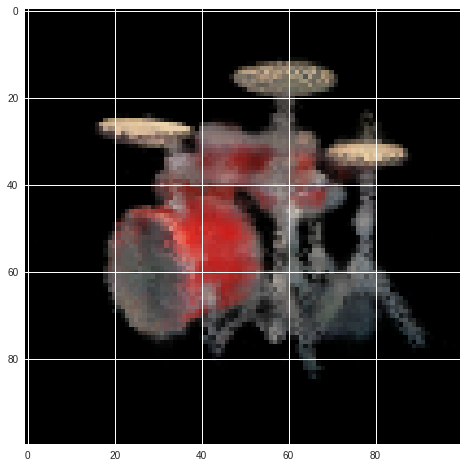

Loss at iteration 1475 is 0.0037089611869305372
PSNR at iteration 1475 is 20.744845201102777
SSIM at iteration 1475 is 0.7528942490819789


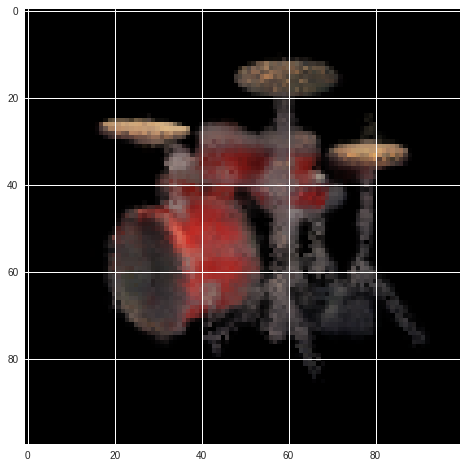

Loss at iteration 1500 is 0.003398758824914694
PSNR at iteration 1500 is 21.002516200654995
SSIM at iteration 1500 is 0.7638922154193624


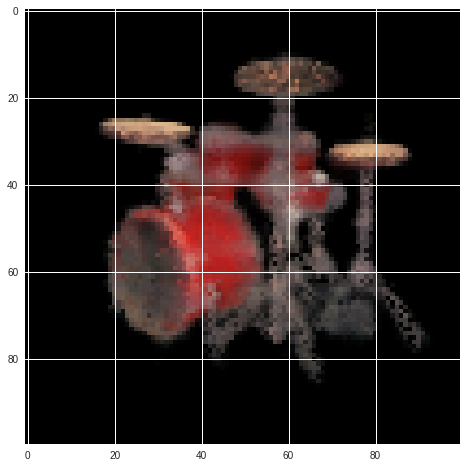

Loss at iteration 1525 is 0.004869813099503517
PSNR at iteration 1525 is 21.442588016512172
SSIM at iteration 1525 is 0.8027031984818698


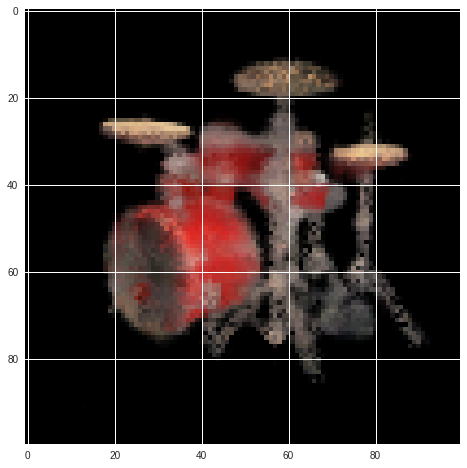

Loss at iteration 1550 is 0.004428665619343519
PSNR at iteration 1550 is 21.411357113451338
SSIM at iteration 1550 is 0.772457527507212


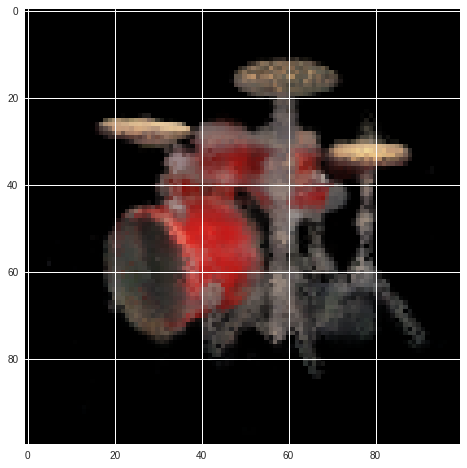

Loss at iteration 1575 is 0.0040978784672915936
PSNR at iteration 1575 is 21.057754786176158
SSIM at iteration 1575 is 0.7842063581037118


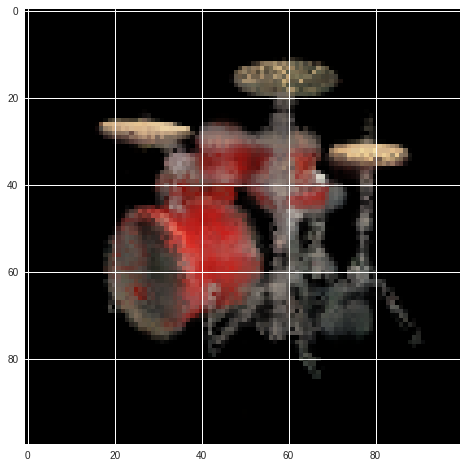

Loss at iteration 1600 is 0.004700352903455496
PSNR at iteration 1600 is 21.529055434216698
SSIM at iteration 1600 is 0.7701578278072304


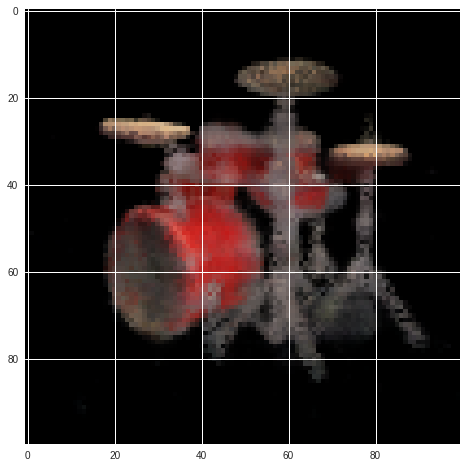

Loss at iteration 1625 is 0.005696432664990425
PSNR at iteration 1625 is 21.05364616528413
SSIM at iteration 1625 is 0.7790956088123241


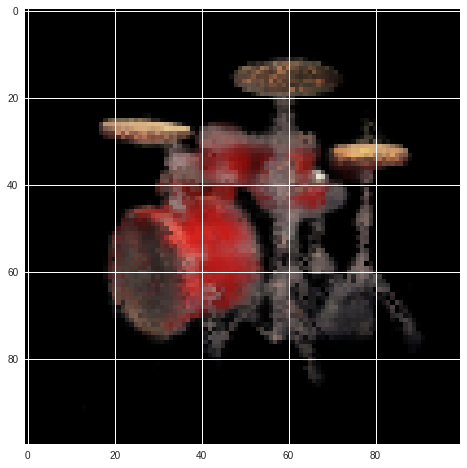

Loss at iteration 1650 is 0.0053331186063587666
PSNR at iteration 1650 is 21.22860838973214
SSIM at iteration 1650 is 0.7771669351041373


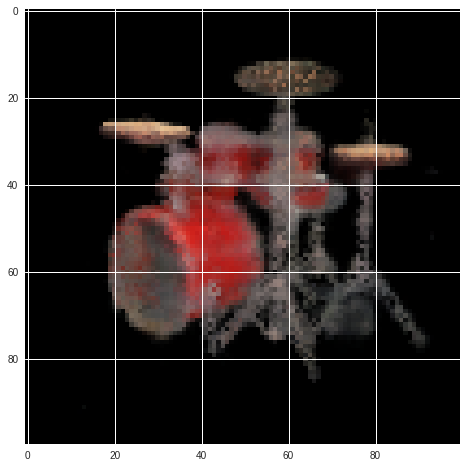

Loss at iteration 1675 is 0.0034194886684417725
PSNR at iteration 1675 is 21.394715542136648
SSIM at iteration 1675 is 0.7858693158366206


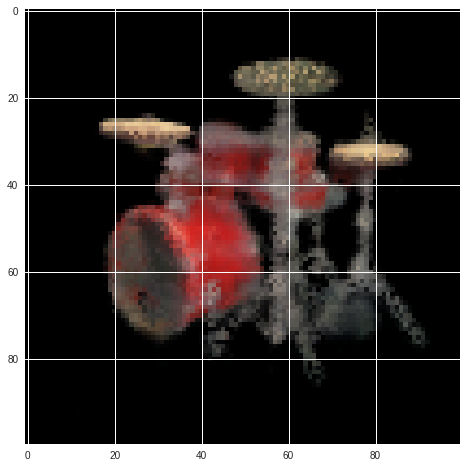

Loss at iteration 1700 is 0.002843062859028578
PSNR at iteration 1700 is 21.665176280917283
SSIM at iteration 1700 is 0.795687103014741


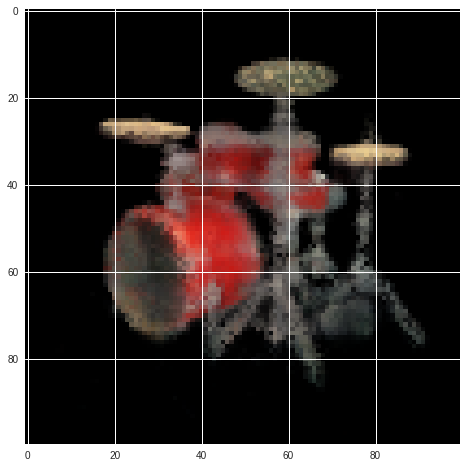

Loss at iteration 1725 is 0.004456453025341034
PSNR at iteration 1725 is 21.395829674213218
SSIM at iteration 1725 is 0.7899311735727901


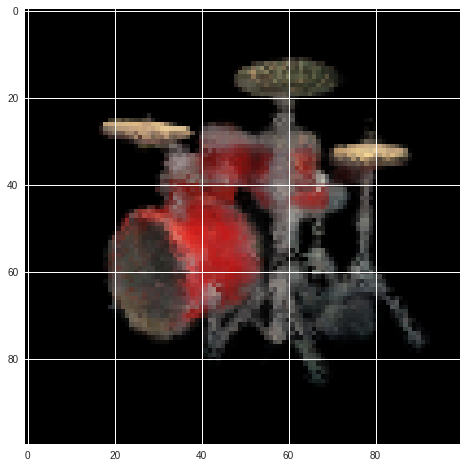

Loss at iteration 1750 is 0.002444968791678548
PSNR at iteration 1750 is 21.5908317798972
SSIM at iteration 1750 is 0.8061548302112023


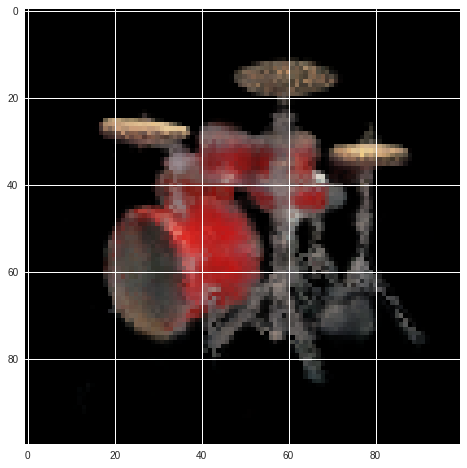

Loss at iteration 1775 is 0.006570861674845219
PSNR at iteration 1775 is 21.26390028350329
SSIM at iteration 1775 is 0.806131998413093


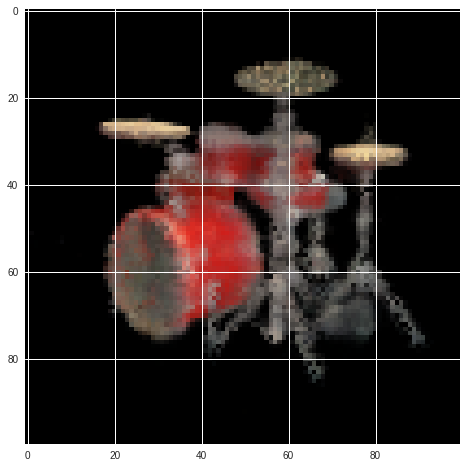

Loss at iteration 1800 is 0.004536457359790802
PSNR at iteration 1800 is 21.492769519261994
SSIM at iteration 1800 is 0.794821545550839


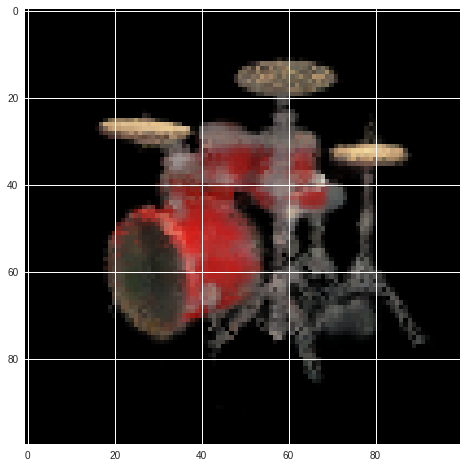

Loss at iteration 1825 is 0.003918434958904982
PSNR at iteration 1825 is 21.661597804656484
SSIM at iteration 1825 is 0.7991502841595768


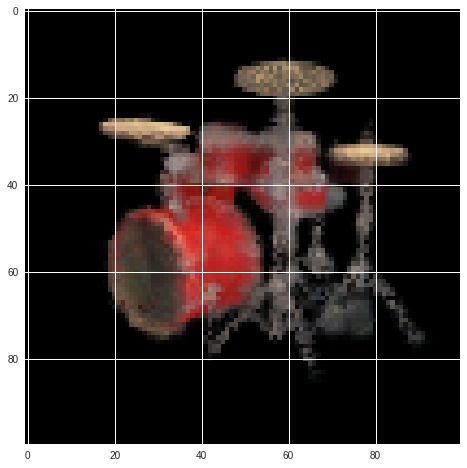

Loss at iteration 1850 is 0.003137293504551053
PSNR at iteration 1850 is 21.495438880315334
SSIM at iteration 1850 is 0.7983653401352049


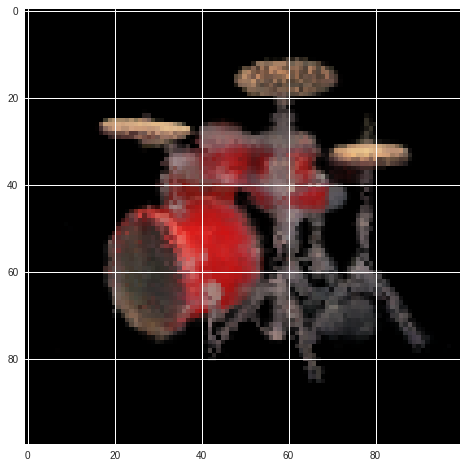

Loss at iteration 1875 is 0.006332941818982363
PSNR at iteration 1875 is 21.333125575428063
SSIM at iteration 1875 is 0.7903344383863451


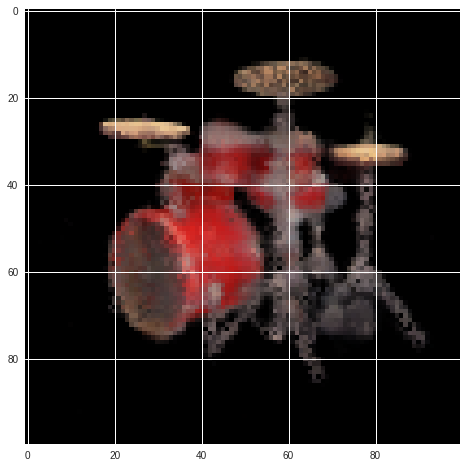

Loss at iteration 1900 is 0.004705278668552637
PSNR at iteration 1900 is 21.601492657090834
SSIM at iteration 1900 is 0.8049111790610013


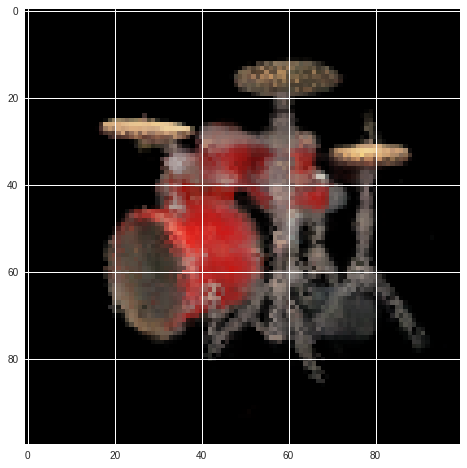

Loss at iteration 1925 is 0.0043877167627215385
PSNR at iteration 1925 is 21.659127247839855
SSIM at iteration 1925 is 0.8044391314082413


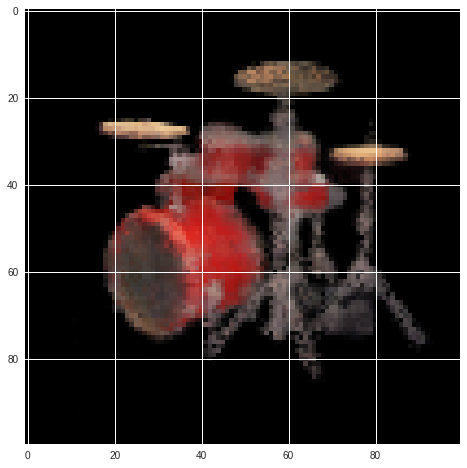

Loss at iteration 1950 is 0.004046597518026829
PSNR at iteration 1950 is 21.201386705444982
SSIM at iteration 1950 is 0.7947381030873489


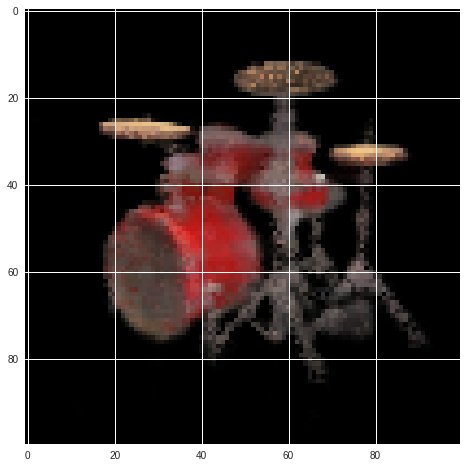

Loss at iteration 1975 is 0.00445129768922925
PSNR at iteration 1975 is 20.884018521187862
SSIM at iteration 1975 is 0.7758433579745466


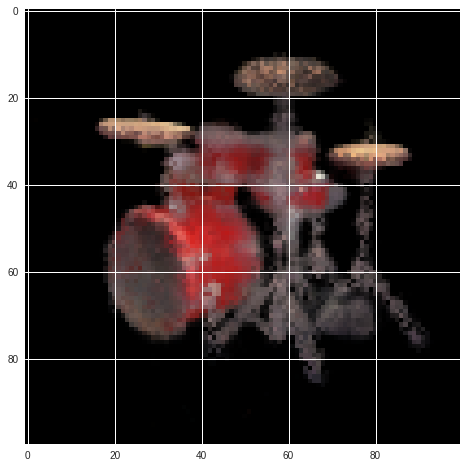

In [ ]:
torch.manual_seed(42)
np.random.seed(2132)

torch.cuda.empty_cache()
nerf_model = NeRF_MLP_reduced(W=hparams['network_width'], inp_dim=3+6*hparams['L'])
nerf_model = nerf_model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(nerf_model.parameters(), lr=hparams['lr'])
optimizer.zero_grad(set_to_none=True)
iterations = hparams['iterations']
num_samples = hparams['num_samples']
focal = torch.tensor(f).to(device)
loss_arr = []
psnr_arr = []
ssim_arr = []
iter_arr = []
for iter in range(iterations):
    rand_index = np.random.randint(images.shape[0])
    img = images[rand_index]
    pos = poses[rand_index]
    pose = torch.tensor(pos).to(device)

    dir_rays, origin_rays = project_rays(H, W, focal, pose)

    if(iter<0):
      optimizer.zero_grad(set_to_none=True)
    else:
      optimizer.zero_grad()
    
    pred_rgb, depth, acc = render_rays(
        nerf_model,
        origin_rays,
        dir_rays,
        near=hparams['near'],
        far=hparams['far'],
        N_samples=hparams['num_samples'],
        rand=True,
        L=hparams['L'],
        batch_size=hparams['batch_size']
    )
    target = torch.tensor(img).to(device)
    loss = criterion(pred_rgb,target)
    loss.backward()
    optimizer.step()
    loss_arr.append(loss.item())
    
    if(iter % 25 == 0):
      print("Loss at iteration", iter, "is", loss.detach().item())
      with torch.no_grad():
        target = torch.from_numpy(testimg).to(device)
        pose = torch.from_numpy(testpose).to(device)
        dir_rays, origin_rays = project_rays(H, W, focal, pose)
        pred_rgb, depth, acc = render_rays(
            nerf_model,
            origin_rays,
            dir_rays,
            near=hparams['near'],
            far=hparams['far'],
            N_samples=hparams['num_samples'],
            rand=True,
            L=hparams['L'],
            batch_size=hparams['batch_size']
        )     
        iter_arr.append(iter)

        psnr = get_psnr(target[..., :3].cpu().detach().numpy(), pred_rgb.cpu().detach().numpy())
        psnr_arr.append(psnr)
        print("PSNR at iteration", iter, "is", psnr)
        
        target_np = target[..., :3].cpu().detach().numpy()
        pred_np = pred_rgb.cpu().detach().numpy()
        
        iter_ssim = get_color_ssim(target_np, pred_np)
        ssim_arr.append(iter_ssim)
        print("SSIM at iteration", iter, "is", iter_ssim)
        
        plt.imshow(pred_rgb.detach().cpu())
        plt.show()

Now, we can look at the training curves!

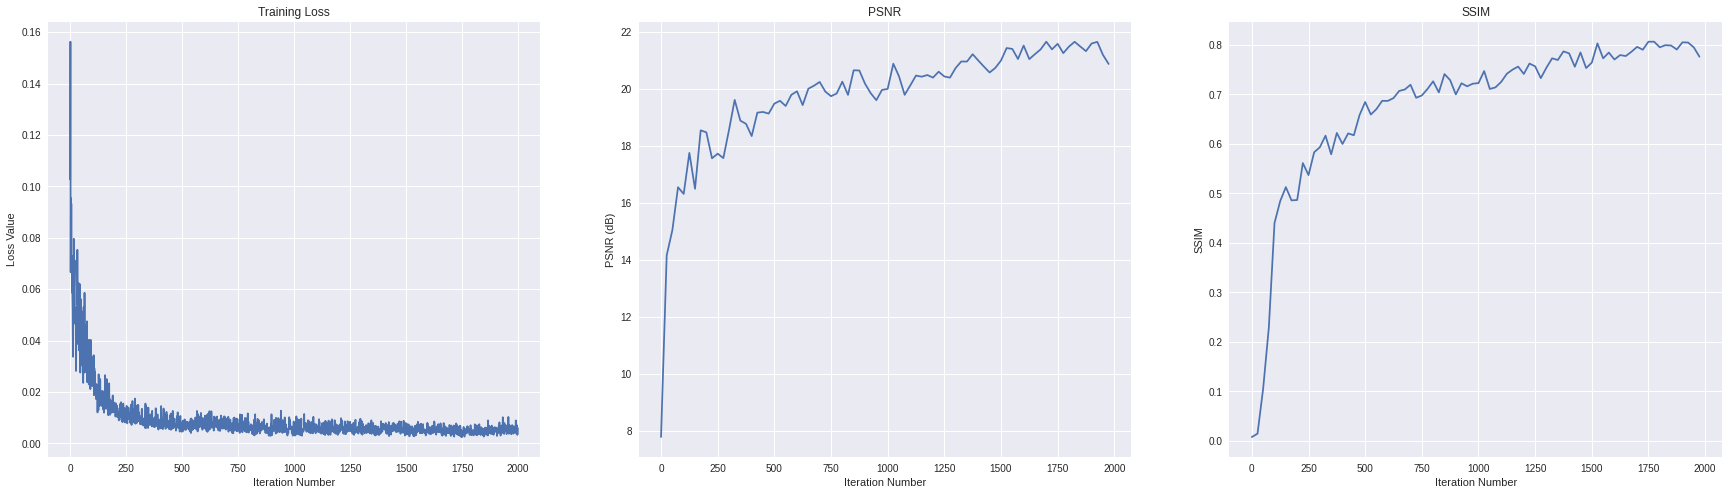

In [ ]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.plot(np.arange(len(loss_arr)),loss_arr)
plt.title('Training Loss')
plt.xlabel('Iteration Number')
plt.ylabel('Loss Value')
plt.subplot(132)
plt.plot(iter_arr, psnr_arr)
plt.title('PSNR')
plt.xlabel('Iteration Number')
plt.ylabel('PSNR (dB)')
plt.subplot(133)
plt.plot(iter_arr, ssim_arr)
plt.title('SSIM')
plt.xlabel('Iteration Number')
plt.ylabel('SSIM')
plt.savefig('training_curves.png')
plt.show()

# Inference

We provide the two inference results to qualitatively and quantively display the performance of our model.

1. We display ground-truth images and predicted rendered images for 5 samples from the training and testing viewpoints for 2 different synthetic datasets. We also display the PSNR and SSIM for each pair.
2. We display video results for 2 different synthetic datasets, where we generate images along a continously moving camera path. 

First, let us re-load the train and test data

In [ ]:
path = os.path.join(GOOGLE_DRIVE_PATH, name+'_data100x100_train.npz')
train_data = np.load(path, allow_pickle=True)
train_images = data['images'][..., :3]
train_poses = data['poses']
f = data['focal']
H, W = images.shape[1:3]

path = os.path.join(GOOGLE_DRIVE_PATH, name+'_data100x100_test.npz')
test_data = np.load(path, allow_pickle=True)
test_images = data['images'][..., :3]
test_poses = data['poses']

## Ground-Truth Comparison

First, let us see the comparison between the ground truth and the predicted image in the train set.


PSNR: 23.650797792270666
SSIM: 0.8601735378081832


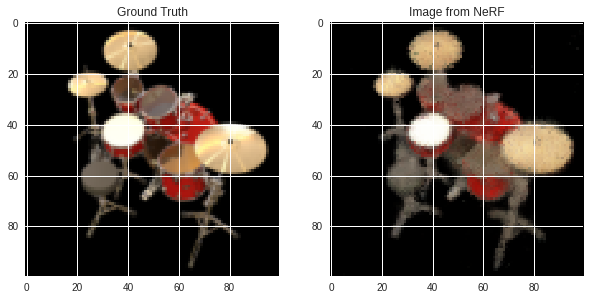

PSNR: 23.37799074932135
SSIM: 0.8669130607530642


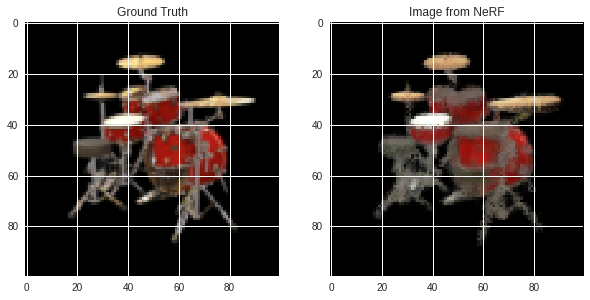

PSNR: 25.293931375707494
SSIM: 0.8831027760579568


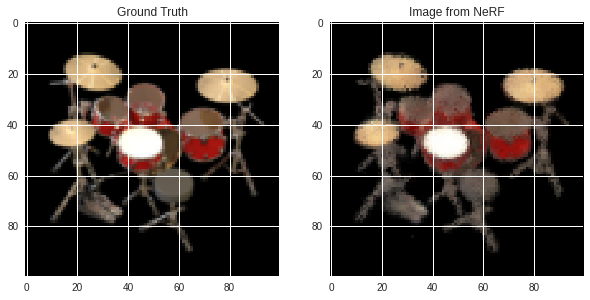

PSNR: 22.46473792868474
SSIM: 0.8461010139987306


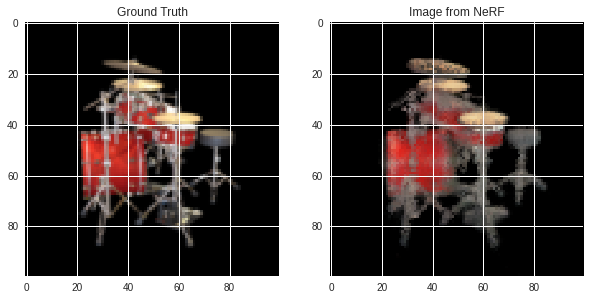

PSNR: 22.436565711640807
SSIM: 0.8249646191326034


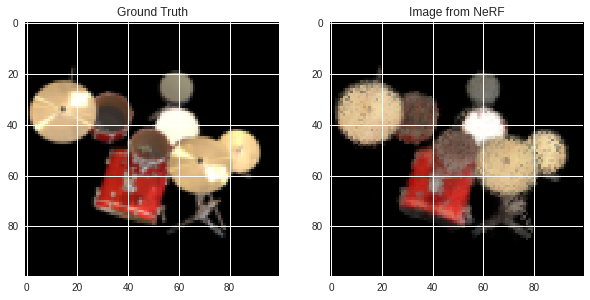

PSNR: 23.350727647484874
SSIM: 0.852798500188819


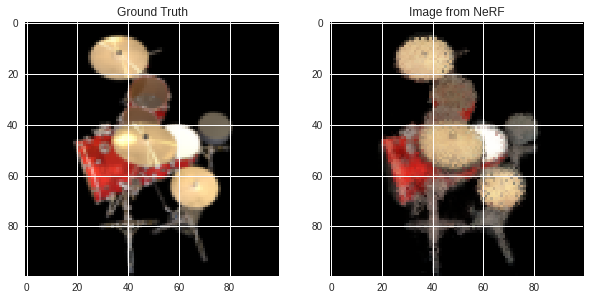

In [ ]:
indices = [2,3,5,7,11,13]
for i in indices:
    f0, axarr = plt.subplots(1,2)
    gt = train_images[i]
    pred = get_image_from_pose(H, W, f, train_poses[i], nerf_model, device).cpu().detach().numpy()
    axarr[0].imshow(gt)
    axarr[0].set_title('Ground Truth')
    axarr[1].imshow(pred)
    axarr[1].set_title('Image from NeRF')
    print("PSNR:", get_psnr(gt, pred))
    print("SSIM:", get_color_ssim(gt, pred))
    plt.show()

Next, let us see the comparison between the ground truth and the predicted image in the train set.

PSNR: 23.735931564887256
SSIM: 0.8625031355666799


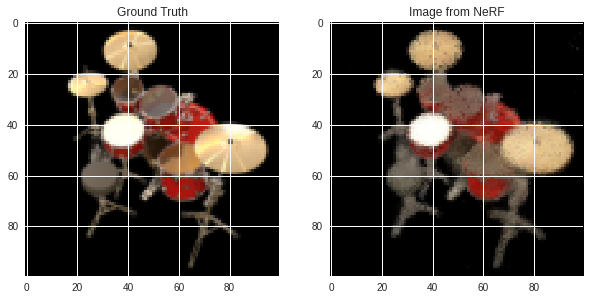

--------------------------------------------------------
PSNR: 23.383244565451932
SSIM: 0.8663462379593816


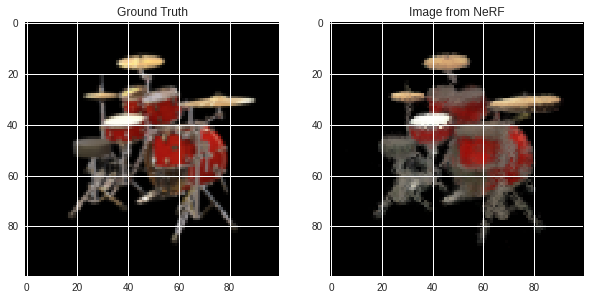

--------------------------------------------------------
PSNR: 25.294357976465438
SSIM: 0.8817333643350522


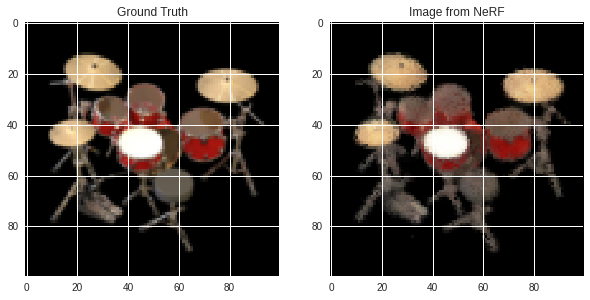

--------------------------------------------------------
PSNR: 22.469772231803955
SSIM: 0.845314811785672


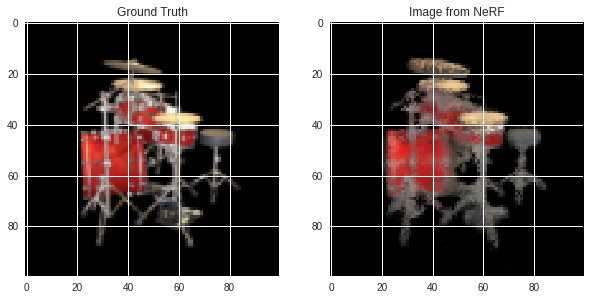

--------------------------------------------------------
PSNR: 22.318061819541274
SSIM: 0.8199269872183256


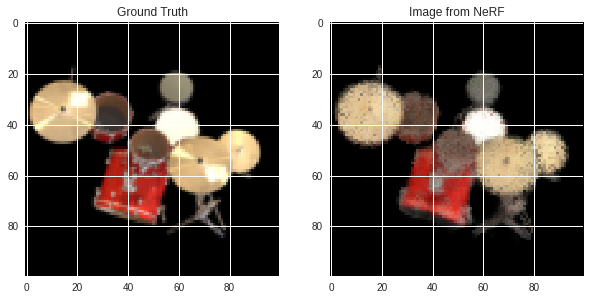

--------------------------------------------------------
PSNR: 23.358744014154755
SSIM: 0.8520947089523295


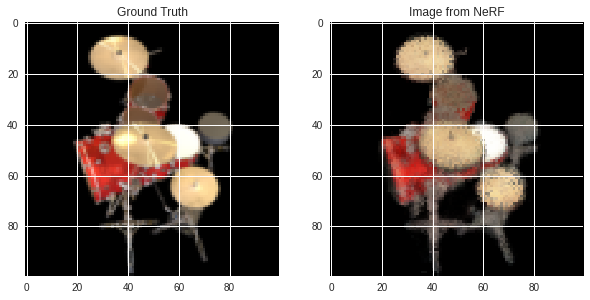

--------------------------------------------------------


In [ ]:
indices = [2,3,5,7,11,13]
for i in indices:
    f0, axarr = plt.subplots(1,2)
    gt = test_images[i]
    pred = get_image_from_pose(H, W, f, test_poses[i], nerf_model, device).cpu().detach().numpy()
    axarr[0].imshow(gt)
    axarr[0].set_title('Ground Truth')
    axarr[1].imshow(pred)
    axarr[1].set_title('Image from NeRF')
    print("PSNR:", get_psnr(gt, pred))
    print("SSIM:", get_color_ssim(gt, pred))
    plt.show()
    print("--------------------------------------------------------")

## Video Results


Finally, we will look at visualization of the NeRF result.

In [ ]:
torch.cuda.empty_cache()
focal = torch.tensor(f).to(device)
frames=[]
for theta in torch.arange(0,360,2, dtype=torch.float32):
    rot_mat_theta = torch.eye(4, dtype=theta.dtype, device=device)
    rot_mat_theta[:2,:2] = rotation_mat(theta*(np.pi/180), theta.dtype ,device)
    camera_mat = rot_mat_theta @ torch.tensor(data['poses'][1]).to(device)
    dir_rays, origin_rays = project_rays(H, W, focal, camera_mat)
    rgb, _, _ = render_rays(nerf_model, origin_rays.to(device), dir_rays.to(device), near=2., far=6., N_samples=num_samples, rand=True, batch_size=1024, L=6)
    final_img = (255*rgb).to(torch.uint8)

    if device == 'cpu':
        final_img = final_img.numpy()
    else:
        final_img = final_img.cpu().detach().numpy()

    frames.append(final_img)

video_file_name = name + '_video.mp4'
imageio.mimwrite(video_file_name, frames, fps=30, quality=7)

In [ ]:
from IPython.display import HTML
from base64 import b64encode
path = name+'_video.mp4'
mp4 = open(path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
<source src="%s" type="video/mp4">
</video>
""" % data_url)

# Conclusion/Future Work

NeRF provides an robust deep learning implementation to synthesize novel views of a 3D scene. Apart from the model architecture proposed in the paper, one other major contribution of the authors is the differentiable volume rendering that plays an important role as it ensures that the neural model is differentiable end-to-end and therefore allows gradient backpropogation. One major drawback of NeRF that we observed and also mentioned in the class, is that we have to train the model for each 3D scene separately. 

We coded the whole implementation from scratch and hence we got a better understanding of underlying nuances of structuring the problem and training the models. The assignments of the course was in a controlled environment and we knew what to expect along the way so we could easily debug where we went wrong if our code threw some error. Understanding and implementating the rendering part of the project was the most challenging since we didn't have any sanity checks to ensure that we were in the right path. We experimented on different types of models that helped us understand the problems behind getting the hyperparameters right for training the models. 

The biggest restriction we had is the limited resources of Colab. Our implementation gave pretty good results(as seen above) for 100x100 resolution images and we were really interested to see results for 200x200 and 400x400 but we couldn't.